
# ANTs × Cellpose Registration QC — Centroid Distances in µm

**Created:** 2025-10-15 12:22

**IMPORTANT:** ANTs transformations of NumPy arrays is finnicky. Export cellpose masks as TIFF instead and transform that to 2P space!

This notebook computes distances (in µm) between **cort-positive cell centroids** segmented by Cellpose in two modalities:
- **Confocal** (panneuronal GC + cort HCR in red) — *moving image* (registered to 2P)
- **2P** (panneuronal GC + cort::mCherry) — *fixed image*

The pipeline:
1. Load Cellpose `*_seg.npy` outputs and extract labeled masks.
2. Compute object centroids.
3. Convert pixel indices to physical units using voxel spacings (µm).
4. Apply the **confocal → 2P** ANTs transform to confocal centroids.
5. Match cells (nearest neighbor or Hungarian) and compute distances in µm.
6. Summaries and basic plots; optional gating to reject outliers.



## Requirements

- `numpy`, `pandas`, `scikit-image`, `scipy`, `matplotlib`
- `ants` (ANTsPy) **optional but recommended** for applying transforms inside Python.
  - If `ants` is not available, the notebook will export centroids to CSV and you can run
    `antsApplyTransformsToPoints` on the command line, then re-import the transformed CSV.

> Tip: For 3D Cellpose, pass correct anisotropy during segmentation to reduce z-bias.


## 0) User inputs

In [ ]:

# --- Paths to Cellpose outputs ---
CONF_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_round1_channel2_cort_gauss_seg_20251006.npy"   # path to confocal *_seg.npy
TWOP_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy"       # path to 2P *_seg.npy

# FILL THESE to the exact images used during registration:
CONF_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/r1/L427_f02_round1_channel2_cort.nrrd"
TWOP_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/2p_anatomy/L427_f02_anatomy_2P_cort.nrrd"

# Inputs:
LABEL_TIFF = "/Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/trainingCort/hcr_test/L427_f02_round1_channel2_cort_gauss_cp_masks.tif"   # 16-bit Cellpose labels (Z,Y,X)

# Transforms (moving=confocal -> fixed=2P)
WARP_PATH   = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz"
AFFINE_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"

# --- ANTs transform files (moving=confocal -> fixed=2P) ---
# include the non-linear warp BEFORE the affine in the list
ANTs_TRANSFORMS = [
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz",          # example SyN warp, forward transformation
    # "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1InverseWarp.nii.gz"    , # example SyN warp, inverse transformation
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"     # example affine
]

# --- Voxel spacings in microns ---
# Fill these from your image metadata
# 3D stacks: dz, dy, dx; 2D stacks: dy, dx
VOX_CONF = {"dz": 1.0, "dy": 0.2075665, "dx": 0.2075665}  # example for confocal
VOX_2P   = {"dz": 2.0, "dy": 0.6506220, "dx": 0.6506220}  # example for 2P

# --- Matching parameters ---
MATCH_METHOD = "nn"    # "nn" for nearest neighbor, "hungarian" for 1–1 global assignment
MAX_DISTANCE_UM = 5.0 # gate for valid matches (~1 soma diameter is a good start)
RANDOM_SEED = 42

INVERT_AFFINE = False  # set to false, at least for images

# Optional global toggle (set once in your params cell)
try:
    INVERT_AFFINE
except NameError:
    INVERT_AFFINE = True  # <-- discovered by your test Variant B

## 1) Imports and helper functions

In [14]:

import os, sys, json, time
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display, HTML
from pathlib import Path
import tifffile as tiff

# Try to import ANTsPy
try:
    import ants
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not found; will enable CSV export/import route for transforms.\n", e)

rng = np.random.default_rng(RANDOM_SEED)

def fs_info(path: str) -> dict:
    """Lightweight filesystem info."""
    exists = os.path.exists(path)
    size_b = os.path.getsize(path) if exists else None
    mtime  = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(path))) if exists else None
    return {"exists": exists, "size_bytes": size_b, "size_MB": (size_b/1e6 if size_b else None), "modified": mtime}

def physical_extent_um(mask: np.ndarray, vox: dict) -> tuple:
    """Return (Z_um, Y_um, X_um) or (Y_um, X_um) physical field-of-view from mask shape and voxel sizes."""
    if mask.ndim == 3:
        Z, Y, X = mask.shape
        return (Z * vox["dz"], Y * vox["dy"], X * vox["dx"])
    else:
        Y, X = mask.shape
        return (Y * vox["dy"], X * vox["dx"])

def summarize_dataset(name: str, path: str, masks: np.ndarray, vox: dict) -> dict:
    """One-row summary for a dataset (used in the table view)."""
    base = os.path.basename(path)
    fs = fs_info(path)
    uniq = np.unique(masks)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    fov = physical_extent_um(masks, vox)
    row = {
        "dataset": name,
        "file": base,
        "path": path,
        "exists": fs["exists"],
        "size_MB": round(fs["size_MB"], 3) if fs["size_MB"] else None,
        "modified": fs["modified"],
        "shape": tuple(masks.shape),
        "ndim": masks.ndim,
        "dtype": str(masks.dtype),
        "min_label": int(masks.min()),
        "max_label": int(masks.max()),
        "n_cells": n_cells,
        "voxel_um": (vox["dz"], vox["dy"], vox["dx"]) if masks.ndim == 3 else (vox["dy"], vox["dx"]),
        "FOV_um": tuple(round(v, 3) for v in fov),
        "n_voxels": int(masks.size),
        "anisotropy_z_over_y": (vox["dz"]/vox["dy"]) if masks.ndim == 3 else None,
    }
    return row

def load_cellpose_masks(seg_path: str) -> np.ndarray:
    """Robustly load Cellpose *_seg.npy (dict) or a raw label array (.npy/.npz).
    Returns a labeled mask ndarray (2D or 3D).
    """
    if not os.path.exists(seg_path):
        raise FileNotFoundError(f"File not found: {seg_path}")

    try:
        obj = np.load(seg_path, allow_pickle=True)
    except Exception as e:
        raise OSError(f"Failed to load {seg_path}. If this is on a network/cloud drive, "
                      f"copy it locally and retry. Original error: {e}")

    # .npz container?
    if isinstance(obj, np.lib.npyio.NpzFile):
        if 'masks' in obj.files:
            return obj['masks']
        raise KeyError(f"{seg_path} is .npz but has no 'masks'. Keys: {obj.files}")

    # Cellpose *_seg.npy is a pickled dict inside an .npy
    if hasattr(obj, "item"):
        try:
            dat = obj.item()
        except Exception as e:
            raise OSError(f"{seg_path} appears corrupted (cannot unpickle dict). {e}")
        masks = dat.get('masks', None)
        if masks is None:
            raise KeyError(f"'masks' not found in {seg_path}. Keys: {list(dat.keys())}")
        return masks

    # raw array case
    if isinstance(obj, np.ndarray):
        return obj

    raise TypeError(f"Unexpected content in {seg_path}: {type(obj)}")

def mask_summary(mask: np.ndarray, name: str = "") -> dict:
    """Return a small dict summarizing a labeled mask."""
    # unique() can be heavy for huge volumes; use it here for truth, but you can swap to mask.max() if needed
    uniq = np.unique(mask)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    return {
        "name": name,
        "shape": tuple(mask.shape),
        "ndim": mask.ndim,
        "dtype": str(mask.dtype),
        "min": int(mask.min()),
        "max": int(mask.max()),
        "n_cells": n_cells,
    }

def safe_slice(arr: np.ndarray, z: int) -> np.ndarray:
    """Return arr[z] for 3D, or arr for 2D, with z safely clamped."""
    if arr.ndim == 2:
        return arr
    z = int(np.clip(z, 0, arr.shape[0] - 1))
    return arr[z]

def _ants_from_mask(mask: np.ndarray, vox: dict, ants):
    """
    Build an ANTsImage from a numpy label mask.
    The NumPy array is (Z,Y,X) for 3D or (Y,X) for 2D.
    ANTs expects spacing in (x,y[,z]) order.
    """
    if mask.ndim == 3:
        img = ants.from_numpy(mask.astype(np.int32))
        img.set_spacing((vox["dx"], vox["dy"], vox["dz"]))
        # origin/direction left at defaults; OK for resampling into a provided reference
    else:
        img = ants.from_numpy(mask.astype(np.int32))
        img.set_spacing((vox["dx"], vox["dy"]))
    return img

def warp_label_mask_with_ants(
    moving_mask: np.ndarray,
    moving_vox: dict,
    fixed_vox: dict,
    transform_list: list,
    ants,
    fixed_mask_for_ref: np.ndarray | None = None,
    fixed_shape: tuple | None = None,
):
    """
    Warp a *label* mask (confocal) into the fixed (2P) space using ANTs transforms.
    - Keeps existing function signature for downstream compatibility.
    - Internally converts (Z,Y,X) -> (X,Y,Z) for ANTs, applies transforms, then returns (Z,Y,X).
    - Uses nearest-neighbor interpolation to preserve label integers.
    - Inverts the affine (.mat) by default (see INVERT_AFFINE), keeps warp forward.
    - Reference grid is taken from fixed_mask_for_ref (preferred) or fixed_shape+fixed_vox.
    """
    import numpy as np
    # 1) Build moving image (labels) in XYZ for ANTs
    if moving_mask.ndim == 3:
        mask_xyz = np.transpose(moving_mask, (2, 1, 0))  # (Z,Y,X) -> (X,Y,Z)
        mov_img = ants.from_numpy(mask_xyz.astype(np.int32, copy=False))
        # spacing must be (dx,dy,dz)
        mov_img.set_spacing((moving_vox["dx"], moving_vox["dy"], moving_vox["dz"]))
    elif moving_mask.ndim == 2:
        mov_img = ants.from_numpy(moving_mask.astype(np.int32, copy=False))
        mov_img.set_spacing((moving_vox["dx"], moving_vox["dy"]))
    else:
        raise ValueError("moving_mask must be 2D or 3D")

    # 2) Build reference image (fixed grid) in XYZ
    if fixed_mask_for_ref is not None:
        if fixed_mask_for_ref.ndim == 3:
            ref_xyz = np.transpose(fixed_mask_for_ref, (2, 1, 0))
            ref_img = ants.from_numpy(ref_xyz.astype(np.int16, copy=False))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"], fixed_vox["dz"]))
        else:
            ref_img = ants.from_numpy(fixed_mask_for_ref.astype(np.int16, copy=False))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"]))
    else:
        if fixed_shape is None:
            raise ValueError("Provide fixed_mask_for_ref or fixed_shape+fixed_vox to define reference space.")
        # fixed_shape is expected in (Z,Y,X) for 3D or (Y,X) for 2D in your code;
        # create an ANTs image of zeros in XYZ for 3D.
        if len(fixed_shape) == 3:
            fx = (fixed_shape[2], fixed_shape[1], fixed_shape[0])
            ref_img = ants.from_numpy(np.zeros(fx, dtype=np.int16))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"], fixed_vox["dz"]))
        else:
            ref_img = ants.from_numpy(np.zeros(fixed_shape, dtype=np.int16))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"]))

    # 3) Build whichtoinvert: keep warp forward, invert affine if requested
    whichtoinvert = []
    for t in transform_list:
        t_str = str(t)
        if t_str.endswith("InverseWarp.nii.gz"):
            # already an inverse warp file → do not invert
            whichtoinvert.append(False)
        elif t_str.endswith("Warp.nii.gz"):
            # forward nonlinear warp → do not invert
            whichtoinvert.append(False)
        elif t_str.endswith(".mat"):
            # affine: invert according to global flag
            whichtoinvert.append(bool(INVERT_AFFINE))
        else:
            # default: do not invert
            whichtoinvert.append(False)

    # 4) Apply transforms (moving -> fixed) with NN (labels)
    warped_xyz = ants.apply_transforms(
        fixed=ref_img,
        moving=mov_img,
        transformlist=transform_list,
        whichtoinvert=whichtoinvert,
        interpolator="nearestNeighbor",
    ).numpy()

    # 5) Return in original layout (Z,Y,X) and dtype preserved
    if moving_mask.ndim == 3:
        warped_zyx = np.transpose(warped_xyz, (2, 1, 0)).astype(moving_mask.dtype, copy=False)
        return warped_zyx
    else:
        return warped_xyz.astype(moving_mask.dtype, copy=False)

def compute_centroids(mask):
    """Return DataFrame of labels and centroids from a labeled mask (2D or 3D)."""
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = pd.DataFrame(props)
    # Ensure consistent column names: z,y,x for 3D; y,x for 2D
    if mask.ndim == 3:
        df = df.rename(columns={"centroid-0":"z", "centroid-1":"y", "centroid-2":"x"})
    else:
        df = df.rename(columns={"centroid-0":"y", "centroid-1":"x"})
    return df

def idx_to_um(df_centroids, vox):
    """Convert centroid indices to microns using spacing dict vox."""
    if "z" in df_centroids.columns:
        arr = df_centroids[["z","y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dz"]
        arr[:,1] *= vox["dy"]
        arr[:,2] *= vox["dx"]
        return arr
    else:
        arr = df_centroids[["y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dy"]
        arr[:,1] *= vox["dx"]
        return arr

def um_to_idx_df(points_um, vox, is3d):
    """Convert points in µm to MOVING image index units with columns x,y,(z)."""
    if is3d:
        return pd.DataFrame({
            "x": points_um[:,2] / vox["dx"],
            "y": points_um[:,1] / vox["dy"],
            "z": points_um[:,0] / vox["dz"],
        })[["x","y","z"]]
    else:
        return pd.DataFrame({
            "x": points_um[:,1] / vox["dx"],
            "y": points_um[:,0] / vox["dy"],
        })[["x","y"]]

def idx_df_to_um(df_idx, vox, is3d):
    """Convert FIXED image index-units DataFrame (x,y,(z)) to µm ndarray (ordered as y/x -> µm & z first for 3D)."""
    if is3d:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy(); z = df_idx["z"].to_numpy()
        return np.c_[ z * vox["dz"],  y * vox["dy"],  x * vox["dx"] ]  # returns [µm_z, µm_y, µm_x]
    else:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy()
        return np.c_[ y * vox["dy"],  x * vox["dx"] ]  # returns [µm_y, µm_x]

def apply_ants_transform_to_points(conf_pts_um, is3d, ants_transforms, vox_conf, vox_2p):
    """Apply confocal->2P transforms to confocal points in µm. Return points in 2P µm."""
    if not HAVE_ANTSPY:
        raise RuntimeError("ANTsPy not available.")
    moving_idx = um_to_idx_df(conf_pts_um, vox_conf, is3d)
    # antspyx signature: apply_transforms_to_points(dim, points, transformlist, whichtoinvert=None)
    fixed_idx = ants.apply_transforms_to_points(3 if is3d else 2, moving_idx, ants_transforms)
    fixed_um = idx_df_to_um(fixed_idx, vox_2p, is3d)
    return fixed_um

def nearest_neighbor_match(A_um, B_um):
    """For each row in A, find nearest neighbor in B. Returns distances and indices."""
    tree = cKDTree(B_um)
    dists, nn = tree.query(A_um, k=1)
    return dists, nn

def hungarian_match(A_um, B_um, max_cost=np.inf):
    """1–1 assignment using Hungarian algorithm with optional max_cost gate."""
    # Compute cost matrix
    # Beware of large N: O(N^2) memory
    from scipy.spatial.distance import cdist
    C = cdist(A_um, B_um)
    if np.isfinite(max_cost):
        C = np.where(C > max_cost, max_cost * 10.0, C)  # penalize invalid matches
    row_ind, col_ind = linear_sum_assignment(C)
    dists = C[row_ind, col_ind]
    return dists, col_ind, row_ind

def summarize_distances(dists, valid_mask):
    if valid_mask.any():
        return {
            "N_total": int(dists.size),
            "N_within_gate": int(valid_mask.sum()),
            "frac_within_gate": float(valid_mask.mean()),
            "median_um": float(np.median(dists[valid_mask])),
            "p90_um": float(np.percentile(dists[valid_mask], 90)),
        }
    else:
        return {
            "N_total": int(dists.size),
            "N_within_gate": 0,
            "frac_within_gate": 0.0,
            "median_um": np.nan,
            "p90_um": np.nan,
        }
    
def array_sample_table(mask: np.ndarray, n: int = 20, name: str = "") -> pd.DataFrame:
    """Return a small DataFrame showing n random voxel entries (z,y,x,value) for intuition.
    Works for 2D or 3D arrays.
    """
    rng = np.random.default_rng(42)
    coords = np.array(np.unravel_index(rng.choice(mask.size, size=min(n, mask.size), replace=False),
                                       mask.shape)).T
    vals = mask.ravel()[np.ravel_multi_index(coords.T, mask.shape)]
    if mask.ndim == 3:
        df = pd.DataFrame(coords, columns=["z","y","x"])
    else:
        df = pd.DataFrame(coords, columns=["y","x"])
    df["value"] = vals
    df.insert(0, "dataset", name)
    return df

def _summary(mask: np.ndarray, name: str):
    uniq = np.unique(mask)
    n_labels = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    print(f"[{name}] shape={mask.shape} ndim={mask.ndim} dtype={mask.dtype} "
          f"min={mask.min()} max={mask.max()} labels(excl 0)={n_labels}")

def _sample_table(mask: np.ndarray, n=20, name=""):
    rng = np.random.default_rng(0 if name=="BEFORE" else 1)  # different seeds
    idx = rng.choice(mask.size, size=min(n, mask.size), replace=False)
    coords = np.array(np.unravel_index(idx, mask.shape)).T
    vals = mask.ravel()[idx]
    if mask.ndim == 3:
        df = pd.DataFrame(coords, columns=["z","y","x"])
    else:
        df = pd.DataFrame(coords, columns=["y","x"])
    df["value"] = vals
    df.insert(0, "dataset", name)
    # sort for readability
    sort_cols = ["z","y","x"] if mask.ndim == 3 else ["y","x"]
    df = df.sort_values(sort_cols).reset_index(drop=True)
    return df

# ---------- Geometry helpers ----------
def clone_geometry_from(img_src, img_dst):
    """Copy spacing, origin, direction from img_src (ANTsImage) to img_dst (ANTsImage); returns img_dst."""
    img_dst.set_spacing(img_src.spacing)
    img_dst.set_origin(img_src.origin)
    img_dst.set_direction(img_src.direction)
    return img_dst

def ants_from_mask_with_geometry(mask_np, like_img, ants, dtype=np.int32):
    """Create ANTsImage from numpy mask and clone geometry from an existing ANTsImage."""
    img = ants.from_numpy(mask_np.astype(dtype))
    return clone_geometry_from(like_img, img)

def index_bounds(ants_img):
    """Return (min_xyz, max_xyz) physical bounds of an ANTs image (exclusive max)."""
    sz = ants_img.shape  # (x,y,z) in ANTs
    sp = ants_img.spacing
    org = ants_img.origin
    # direction is a 3x3
    import numpy as _np
    D = _np.array(ants_img.direction).reshape(3,3)
    max_idx = _np.array(sz) - 1
    # corners: 0..max -> physical via origin + D*(idx*spacing)
    corners = []
    for ix in [0, max_idx[0]]:
        for iy in [0, max_idx[1]]:
            for iz in [0, max_idx[2]] if len(sz) == 3 else [0]:
                p = org + D.dot(_np.array([ix*sp[0], iy*sp[1], iz*sp[2] if len(sz)==3 else 0.0]))
                corners.append(p)
    corners = _np.vstack(corners)
    return corners.min(axis=0), corners.max(axis=0)

def points_inside_fixed(points_xyz, fixed_img):
    """Return boolean mask whether each (x,y,z) point lies within fixed image physical bounds (inclusive)."""
    import numpy as _np
    lo, hi = index_bounds(fixed_img)
    P = _np.asarray(points_xyz)
    return (P >= lo).all(axis=1) & (P <= hi).all(axis=1)

def _ants_clone_geometry(dst_img, like_img):
    """Copy spacing, origin, direction from like_img to dst_img (both ANTs images)."""
    dst_img.set_spacing(like_img.spacing)
    dst_img.set_origin(like_img.origin)
    dst_img.set_direction(like_img.direction)
    return dst_img

def warp_label_tiff_with_ants(
    tiff_path: str | Path,
    mov_img_int,           # ants image (the moving intensity used for registration)
    fix_img_int,           # ants image (the fixed intensity used for registration)
    warp_path: str,        # forward warp .nii.gz   (fixed->moving in ANTs convention)
    affine_path: str,      # affine .mat            (fixed->moving; we will invert it)
    ants,
    vox_moving: dict | None = None,  # {"dx":..,"dy":..,"dz":..} if you need to sanity-check spacing
    save_basename: str | None = None # without extension; if None, derive from tiff_path
):
    """
    Warp a Cellpose 16-bit TIFF label volume (Z,Y,X) into the fixed (2P) space.
    - Reads TIFF as uint16 labels (0=bg, 1..=IDs)
    - Transposes ZYX->XYZ for ANTs, clones geometry from mov_img_int
    - Applies [warp, affine] with affine inversion (INVERT_AFFINE)
    - NN interpolation to preserve integer labels
    - Returns warped labels as NumPy array (Z,Y,X), dtype=int32
    - Writes uint16 TIFF if maxID<=65535; else writes NIfTI and .npy

    Returns: warped_zyx (np.ndarray, int32), out_paths (dict)
    """
    tiff_path = Path(tiff_path)
    lab_zyx = tiff.imread(str(tiff_path))  # (Z,Y,X), uint16 from Cellpose GUI
    if lab_zyx.ndim != 3:
        raise ValueError(f"Expected 3D TIFF (Z,Y,X); got shape {lab_zyx.shape}")

    # transpose to (X,Y,Z) for ANTs memory order
    lab_xyz = np.transpose(lab_zyx, (2,1,0)).astype(np.int32, copy=False)

    # create ANTs image and clone geometry from moving intensity used in registration
    mov_label_img = ants.from_numpy(lab_xyz)
    _ants_clone_geometry(mov_label_img, mov_img_int)

    # safety checks
    if mov_label_img.shape != mov_img_int.shape:
        raise RuntimeError(
            f"Label XYZ shape {mov_label_img.shape} != moving intensity XYZ shape {mov_img_int.shape} "
            "(label TIFF must correspond to the same grid used for registration)."
        )
    if vox_moving is not None:
        dx,dy,dz = mov_img_int.spacing
        if not np.allclose([dx,dy,dz],[vox_moving["dx"],vox_moving["dy"],vox_moving["dz"]], rtol=0, atol=1e-6):
            print("[WARN] mov_img_int.spacing differs from provided vox_moving – using mov_img_int.spacing.")

    # transform list and inversion flags
    transformlist = [str(warp_path), str(affine_path)]
    whichtoinvert = [False, bool(INVERT_AFFINE)]  # <- critical: invert affine, keep warp forward

    warped_xyz = ants.apply_transforms(
        fixed=fix_img_int,
        moving=mov_label_img,
        transformlist=transformlist,
        whichtoinvert=whichtoinvert,
        interpolator="nearestNeighbor",
    ).numpy().astype(np.int32, copy=False)

    # back to (Z,Y,X)
    warped_zyx = np.transpose(warped_xyz, (2,1,0))

    # prepare outputs
    if save_basename is None:
        save_basename = str(tiff_path.with_suffix("")) + "_in_fixed"
    out = {}

    max_id = int(warped_zyx.max())
    nz = int((warped_zyx > 0).sum())
    print(f"[warp_label_tiff_with_ants] warped shape(ZYX)={warped_zyx.shape} maxID={max_id} nonzero={nz}")

    if max_id <= 65535:
        # safe TIFF export
        out_tif = save_basename + "_labels_uint16.tif"
        tiff.imwrite(out_tif, warped_zyx.astype(np.uint16))
        out["tif"] = out_tif
    else:
        # keep full IDs
        out_npy = save_basename + "_labels_int32.npy"
        np.save(out_npy, warped_zyx)
        out["npy"] = out_npy
        # also NIfTI with geometry for viewing in ITK/Fiji
        warped_img = ants.from_numpy(np.transpose(warped_zyx, (2,1,0)))  # back to XYZ
        _ants_clone_geometry(warped_img, fix_img_int)
        out_nii = save_basename + "_labels_int32.nii.gz"
        ants.image_write(warped_img, out_nii)
        out["nii"] = out_nii

    return warped_zyx, out


## 2) Inspect datasets

Masks are represented by a .npy array (z, y, x, label) that represent the voxel location in space and to which cells they belong (0 = background). There should be non-zero labels if any cells are found by cellpose.

,dataset,file,exists,size_MB,modified,shape,ndim,dtype,min_label,max_label,n_cells,nonzero_voxels,frac_nonzero_pct,voxel_um,FOV_um,n_voxels,anisotropy_z_over_y,path
0,Confocal (HCR),L427_f02_round1_channel2_cort_gauss_seg_202510...,True,16252.932,2025-10-15 07:15:07,"(155, 2048, 2048)",3,uint16,0,191,191,850366,0.1308,"(1.0, 0.2075665, 0.2075665)","(155.0, 425.096, 425.096)",650117120,4.817733,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...
1,2P (mCherry),L427_f02_anatomy_2P_cort_seg_anis1.npy,True,2756.266,2025-10-06 09:32:37,"(196, 750, 750)",3,uint16,0,939,939,322698,0.2927,"(2.0, 0.650622, 0.650622)","(392.0, 487.967, 487.967)",110250000,3.073982,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...


Saved table to input_datasets_overview.csv

Random voxel samples (label structure):


dataset,z,y,x,value
Confocal,14,1223,1345,0
Confocal,119,1972,1231,0
Confocal,130,329,1386,0
Confocal,69,1658,1048,0
Confocal,114,85,470,0
Confocal,31,466,1000,0
Confocal,111,427,2017,0
Confocal,79,1126,1315,0
Confocal,13,1707,1683,0
Confocal,101,939,363,0


Saved array_structure_samples.csv

Per-Z nonzero counts & preview (Confocal):


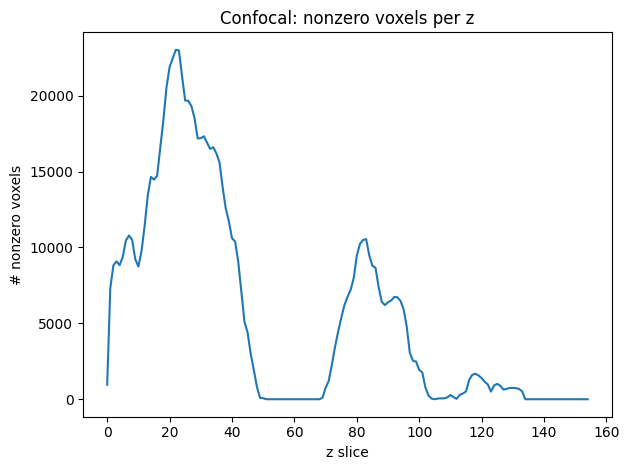

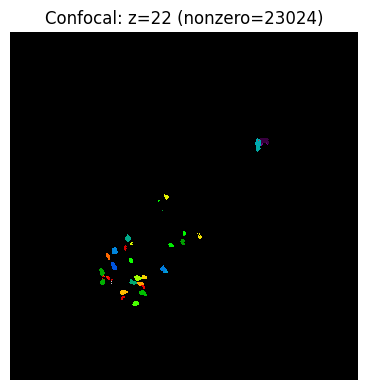

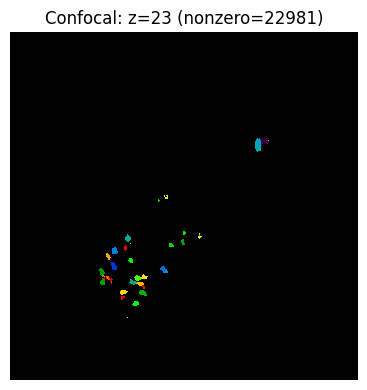

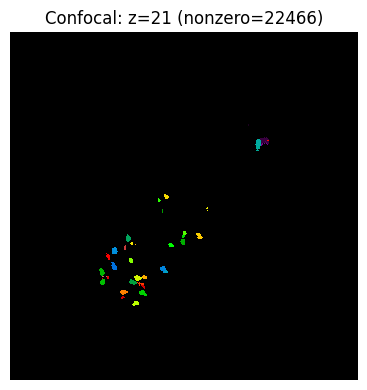


Per-Z nonzero counts & preview (2P):


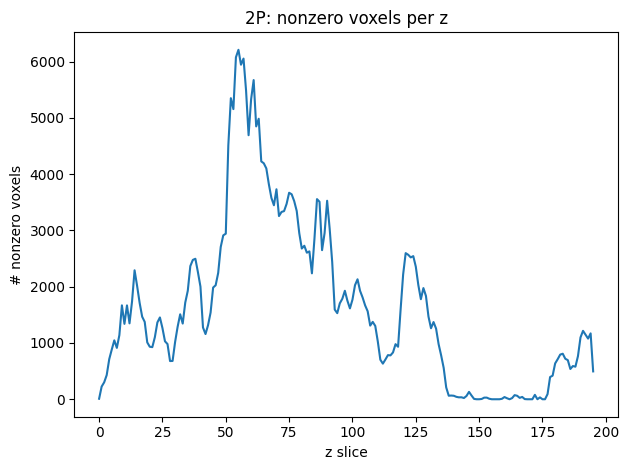

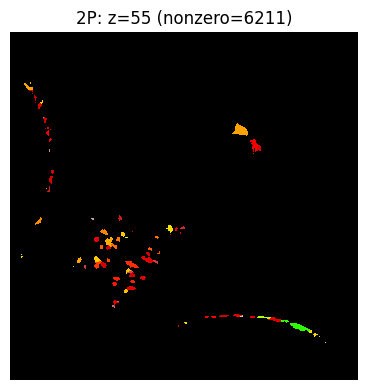

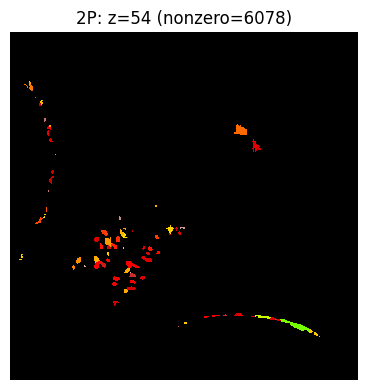

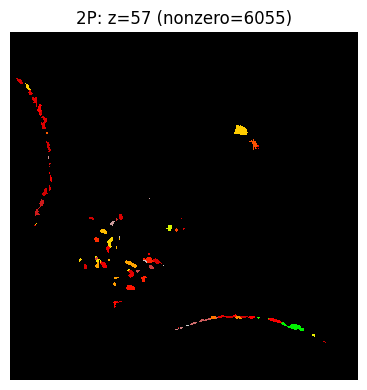

In [3]:
# ==== Expanded oversight: verify non-zero labels in inputs (confocal & 2P) ====
# Load (robust helper already handles dict/raw npy)
masks_conf = load_cellpose_masks(CONF_SEG_NPY)
masks_2p   = load_cellpose_masks(TWOP_SEG_NPY)

# Build the basic table (your original)
rows = [
    summarize_dataset("Confocal (HCR)", CONF_SEG_NPY, masks_conf, VOX_CONF),
    summarize_dataset("2P (mCherry)",   TWOP_SEG_NPY, masks_2p,   VOX_2P),
]
df_inputs = pd.DataFrame(rows)

# ---- NEW: add explicit non-zero voxel stats ----
def _nz_stats(mask: np.ndarray):
    nz = int((mask > 0).sum())
    frac = nz / mask.size
    if mask.ndim == 3:
        nz_per_z = (mask > 0).reshape(mask.shape[0], -1).sum(axis=1)
    else:
        nz_per_z = None
    return nz, frac, nz_per_z

nz_conf, frac_conf, nz_per_z_conf = _nz_stats(masks_conf)
nz_2p,   frac_2p,   nz_per_z_2p   = _nz_stats(masks_2p)

df_inputs["nonzero_voxels"]     = [nz_conf, nz_2p]
df_inputs["frac_nonzero_pct"]   = [round(frac_conf*100, 4), round(frac_2p*100, 4)]
df_inputs["has_any_labels"]     = [nz_conf > 0, nz_2p > 0]

# Choose readable column order
cols = [
    "dataset","file","exists","size_MB","modified",
    "shape","ndim","dtype","min_label","max_label","n_cells",
    "nonzero_voxels","frac_nonzero_pct",
    "voxel_um","FOV_um","n_voxels","anisotropy_z_over_y","path"
]
df_inputs = df_inputs[cols]

# Robust display (works without jinja2)
df_show = df_inputs.copy()
if "size_MB" in df_show.columns:
    df_show["size_MB"] = df_show["size_MB"].apply(lambda x: None if x is None else round(x, 3))
display(df_show)

df_inputs.to_csv("input_datasets_overview.csv", index=False)
print("Saved table to input_datasets_overview.csv")

# ---- NEW: random voxel samples (your original), kept for intuition ----
print("\nRandom voxel samples (label structure):")
df_conf_samp = array_sample_table(masks_conf, n=20, name="Confocal")
df_2p_samp   = array_sample_table(masks_2p,   n=20, name="2P")
df_samples = pd.concat([df_conf_samp, df_2p_samp], ignore_index=True)
display(HTML(df_samples.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:300px; overflow-y:auto; width:100%;"')))
df_samples.to_csv("array_structure_samples.csv", index=False)
print("Saved array_structure_samples.csv")

# ---- NEW: per-Z nonzero counts + quick preview of densest slices (3D only) ----
def _plot_nz_per_z(mask, title_prefix):
    if mask.ndim != 3:
        return
    nz_per_z = (mask > 0).reshape(mask.shape[0], -1).sum(axis=1)
    plt.figure()
    plt.plot(np.arange(mask.shape[0]), nz_per_z)
    plt.xlabel("z slice"); plt.ylabel("# nonzero voxels")
    plt.title(f"{title_prefix}: nonzero voxels per z")
    plt.tight_layout(); plt.show()
    # show up to 3 densest planes
    top = np.argsort(nz_per_z)[::-1][:3]
    for z in top:
        if nz_per_z[z] == 0:
            continue
        plt.figure(figsize=(4,4))
        plt.imshow(mask[z], cmap="nipy_spectral", interpolation="nearest")
        plt.title(f"{title_prefix}: z={z} (nonzero={int(nz_per_z[z])})")
        plt.axis("off"); plt.tight_layout(); plt.show()

print("\nPer-Z nonzero counts & preview (Confocal):")
_plot_nz_per_z(masks_conf, "Confocal")
print("\nPer-Z nonzero counts & preview (2P):")
_plot_nz_per_z(masks_2p, "2P")

## 3) Transform masks to 2P space

In [13]:
# ==== Warp confocal label mask into 2P space (create a 2P-space .npy you can feed to Cellpose) ====
if not HAVE_ANTSPY:
    raise RuntimeError("ANTsPy is required for label-volume warping in-notebook. (CLI fallback possible with antsApplyTransforms)")

# Build 2P-space label volume from confocal labels
print("Warping confocal labels into 2P space with nearest-neighbor interpolation …")
conf_warped_in_2p = warp_label_mask_with_ants(
    moving_mask=masks_conf,
    moving_vox=VOX_CONF,
    fixed_vox=VOX_2P,
    transform_list=ANTs_TRANSFORMS,   # order: warp.nii.gz BEFORE affine.mat
    ants=ants,
    fixed_mask_for_ref=masks_2p       # ensures identical shape/grid to your 2P mask
)

print("Done. Shapes — 2P mask:", masks_2p.shape, " | warped confocal→2P:", conf_warped_in_2p.shape)

# Quick integrity check
print("Unique labels (excluding 0):",
      int(np.unique(conf_warped_in_2p).size - (1 if np.unique(conf_warped_in_2p)[0] == 0 else 0)))

# Save for later / external inspection
out_npy = "confocal_labels_in_2P_space.npy"
np.save(out_npy, conf_warped_in_2p)
print(f"Saved: {os.path.abspath(out_npy)}")

# Optional: quick side-by-side visualization at a chosen z
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

assert conf_warped_in_2p.ndim == 3 and masks_2p.ndim == 3, "Viewer expects 3D stacks."

Z = masks_2p.shape[0]
def _view(z=0):
    z = int(np.clip(z, 0, Z-1))
    fig, ax = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
    ax[0].imshow(conf_warped_in_2p[z], cmap="nipy_spectral", interpolation="nearest")
    ax[0].set_title(f"Warped Conf→2P  (z={z}/{Z-1})"); ax[0].axis("off")
    ax[1].imshow(masks_2p[z], cmap="nipy_spectral", interpolation="nearest")
    ax[1].set_title(f"Native 2P mask (z={z}/{Z-1})"); ax[1].axis("off")
    # sync display range so colors map comparably by label id
    vmax = max(conf_warped_in_2p[z].max(), masks_2p[z].max())
    for a in ax: a.images[0].set_clim(0, vmax)
    plt.show()

interact(_view, z=IntSlider(min=0, max=Z-1, step=1, value=min(Z//2, Z-1), description="z-plane"));


Warping confocal labels into 2P space with nearest-neighbor interpolation …


NameError: name 'masks_conf' is not defined

## 3) Transform mask TIFF to 2P space

In [17]:
# Read the SAME images used for registration (geometry source of truth)
mov_img_int = ants.image_read(CONF_NRRD_PATH)  # moving intensity
fix_img_int = ants.image_read(TWOP_NRRD_PATH)  # fixed intensity

# Run warp (NN labels, invert affine)
warped_labels_zyx, out_paths = warp_label_tiff_with_ants(
    tiff_path=LABEL_TIFF,
    mov_img_int=mov_img_int,
    fix_img_int=fix_img_int,
    warp_path=WARP_PATH,
    affine_path=AFFINE_PATH,
    ants=ants,
    vox_moving=None,                # optional; geometry is cloned from mov_img_int anyway
    save_basename="confocal_labels_in_2P_space"
)

print("Saved:", out_paths)

# Quick sanity prints
print("Warped labels nonzero:", int((warped_labels_zyx>0).sum()))
print("Unique labels (<=20 shown):", np.unique(warped_labels_zyx)[:20])

[warp_label_tiff_with_ants] warped shape(ZYX)=(196, 750, 750) maxID=191 nonzero=56237
Saved: {'tif': 'confocal_labels_in_2P_space_labels_uint16.tif'}
Warped labels nonzero: 56237
Unique labels (<=20 shown): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## 4) Load Cellpose masks and compute centroids

In [ ]:
is3d = (masks_conf.ndim == 3)
assert masks_2p.ndim == masks_conf.ndim, "Confocal and 2P masks must have same dimensionality (both 2D or both 3D)."

df_conf = compute_centroids(masks_conf)
df_2p   = compute_centroids(masks_2p)

print("Confocal centroids:", df_conf.shape, "| 2P centroids:", df_2p.shape)
df_conf.head(), df_2p.head()

# Print concise summaries
for m, n in [(masks_conf, "Confocal (HCR)"), (masks_2p, "2P (mCherry)")]:
    s = mask_summary(m, n)
    print(f"[{s['name']}] shape={s['shape']} ndim={s['ndim']} dtype={s['dtype']} "
          f"min={s['min']} max={s['max']} cells={s['n_cells']}")

# # Interactive viewer
# def _browse(which: str = "Confocal", z: int = 0):
#     arr = masks_conf if which == "Confocal" else masks_2p
#     img = safe_slice(arr, z)
#     plt.figure()
#     plt.imshow(img, cmap="nipy_spectral", interpolation="nearest")
#     if arr.ndim == 3:
#         plt.title(f"{which} — z={int(np.clip(z, 0, arr.shape[0]-1))}/{arr.shape[0]-1}")
#     else:
#         plt.title(f"{which} — 2D mask")
#     plt.axis("off")
#     plt.tight_layout()
#     plt.show()

# # Set slider range to cover the larger Z; safe_slice() clamps for the smaller stack.
# zmax = max(masks_conf.shape[0] if masks_conf.ndim == 3 else 1,
#            masks_2p.shape[0]   if masks_2p.ndim   == 3 else 1) - 1
# interact(
#     _browse,
#     which=Dropdown(options=["Confocal", "2P"], value="Confocal", description="Stack"),
#     z=IntSlider(min=0, max=max(0, zmax), step=1, value=0, description="z-plane")
# );

assert masks_conf.ndim == 3 and masks_2p.ndim == 3, "This viewer is for 3D stacks."

Zc, Zt = masks_conf.shape[0], masks_2p.shape[0]
zmax = max(Zc, Zt) - 1

def _browse_pair(z=0):
    # clamp independently so the slider always works even if Z counts differ
    zc = int(np.clip(z, 0, Zc-1))
    zt = int(np.clip(z, 0, Zt-1))
    imc = safe_slice(masks_conf, zc)
    imt = safe_slice(masks_2p,   zt)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    axL, axR = axes

    im0 = axL.imshow(imc, cmap="nipy_spectral", interpolation="nearest")
    axL.set_title(f"Confocal (HCR)\nZ={zc}/{Zc-1}  shape={imc.shape}")
    axL.axis("off")

    im1 = axR.imshow(imt, cmap="nipy_spectral", interpolation="nearest")
    axR.set_title(f"2P (mCherry)\nZ={zt}/{Zt-1}  shape={imt.shape}")
    axR.axis("off")

    # keep identical display ranges so colors map comparably across z (optional)
    vmax = max(imc.max(), imt.max())
    im0.set_clim(0, vmax)
    im1.set_clim(0, vmax)

    plt.show()

interact(
    _browse_pair,
    z=IntSlider(min=0, max=zmax, step=1, value=min(Zc, Zt)//2, description="z-plane"),
);

Confocal centroids: (191, 4) | 2P centroids: (939, 4)
[Confocal (HCR)] shape=(155, 2048, 2048) ndim=3 dtype=uint16 min=0 max=191 cells=191
[2P (mCherry)] shape=(196, 750, 750) ndim=3 dtype=uint16 min=0 max=939 cells=939


interactive(children=(IntSlider(value=77, description='z-plane', max=195), Output()), _dom_classes=('widget-in…

## 5) Convert centroids to physical units (µm)

In [7]:

P_conf_um = idx_to_um(df_conf, VOX_CONF)
P_2p_um   = idx_to_um(df_2p,   VOX_2P)
print(f"P_conf_um shape: {P_conf_um.shape}, P_2p_um shape: {P_2p_um.shape}")



P_conf_um shape: (191, 3), P_2p_um shape: (939, 3)


## 6) Apply ANTs transform (confocal → 2P)

In [8]:

if HAVE_ANTSPY:
    print("Applying ANTs transform via ANTsPy...")
    P_conf_in_2p_um = apply_ants_transform_to_points(P_conf_um, is3d, ANTs_TRANSFORMS, VOX_CONF, VOX_2P)
else:
    print("ANTsPy not available. Exporting confocal centroids to CSV for antsApplyTransformsToPoints...")
    export_csv = "conf_centroids_input_points.csv"
    # antsApplyTransformsToPoints expects columns: x,y,(z) in index units of the MOVING image.
    moving_idx = um_to_idx_df(P_conf_um, VOX_CONF, is3d)
    moving_idx.to_csv(export_csv, index=False)
    print(f"Wrote {export_csv}.")
    print("""
Next steps (outside Python):
  antsApplyTransformsToPoints -d {2 if not is3d else 3}     -i conf_centroids_input_points.csv     -o conf_centroids_in_2p_index.csv     -t { ' -t '.join(ANTs_TRANSFORMS) }     --precision float
Then re-import here:
    fixed_idx = pd.read_csv("conf_centroids_in_2p_index.csv")
    P_conf_in_2p_um = idx_df_to_um(fixed_idx, VOX_2P, is3d)
""".strip())
    P_conf_in_2p_um = None


Applying ANTs transform via ANTsPy...


## 7) Match cells and compute distances

In [12]:
if P_conf_in_2p_um is None:
    raise RuntimeError("Transformed confocal centroids not available yet. Complete the ANTs step then re-run.")

labels_conf = df_conf["label"].to_numpy()
labels_2p   = df_2p["label"].to_numpy()

# --- matching ---
if MATCH_METHOD == "nn":
    dists, nn = nearest_neighbor_match(P_conf_in_2p_um, P_2p_um)
    matched_twoP_labels = labels_2p[nn]
    matched_conf_labels = labels_conf
elif MATCH_METHOD == "hungarian":
    dists, col_ind, row_ind = hungarian_match(P_conf_in_2p_um, P_2p_um, max_cost=np.inf)
    matched_conf_labels = labels_conf[row_ind]
    matched_twoP_labels = labels_2p[col_ind]
else:
    raise ValueError("MATCH_METHOD must be 'nn' or 'hungarian'")

# --- construct table ---
valid = dists <= MAX_DISTANCE_UM
matches = pd.DataFrame({
    "conf_label": matched_conf_labels,
    "twoP_label": matched_twoP_labels,
    "distance_um": dists,
    "within_gate": valid
}).sort_values("distance_um", ascending=True).reset_index(drop=True)

# --- display (scrollable HTML table) ---
# display(HTML(matches.to_html(index=False, max_rows=30, escape=False, notebook=True)))
# replace the display() line with this one-liner:
display(HTML(matches.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:600px; overflow-y:auto; width:100%;"')))

# --- summary stats ---
summary = summarize_distances(dists, valid)
print("Summary:", json.dumps(summary, indent=2))

# --- optional: save ---
matches.to_csv("centroid_matches_sorted.csv", index=False)
print("Saved centroid_matches_sorted.csv")

conf_label,twoP_label,distance_um,within_gate
114,469,198.041765,False
104,469,198.404930,False
115,469,203.958323,False
140,469,208.571075,False
146,469,209.262136,False
144,469,210.263144,False
152,469,210.323979,False
149,469,212.174824,False
145,469,212.338148,False
141,469,212.490499,False


Summary: {
  "N_total": 191,
  "N_within_gate": 0,
  "frac_within_gate": 0.0,
  "median_um": NaN,
  "p90_um": NaN
}
Saved centroid_matches_sorted.csv


## 8) Plots

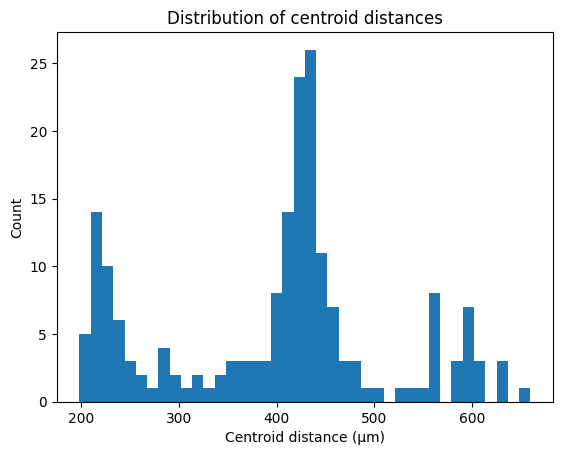

In [13]:

# Distance histogram
plt.figure()
plt.hist(matches["distance_um"].to_numpy(), bins=40)
plt.xlabel("Centroid distance (µm)")
plt.ylabel("Count")
plt.title("Distribution of centroid distances")
plt.show()


In [ ]:
try:
    from ipywidgets import interact, FloatSlider, FloatLogSlider, Checkbox
except Exception as e:
    print("ipywidgets not available:", e)
    raise

# convenience projections
Z2, Y2, X2 = P_2p_um[:,0], P_2p_um[:,1], P_2p_um[:,2]
Zc, Yc, Xc = P_conf_in_2p_um[:,0], P_conf_in_2p_um[:,1], P_conf_in_2p_um[:,2]

zmin = float(min(Z2.min(), Zc.min()))
zmax = float(max(Z2.max(), Zc.max()))
default_thick = 4.0  # µm half-thickness on each side of the slider plane

def _plot_slice(z_um=0.0, thickness_um=default_thick, show_conf=True, show_2p=True, show_matches=False):
    plt.figure()
    # 2P points in the slab
    if show_2p:
        m2 = np.abs(Z2 - z_um) <= thickness_um
        plt.scatter(X2[m2], Y2[m2], s=8, label="2P", alpha=0.9)
    # confocal→2P points in the slab
    if show_conf:
        mc = np.abs(Zc - z_um) <= thickness_um
        plt.scatter(Xc[mc], Yc[mc], s=8, alpha=0.6, label="Conf→2P")
    # optional: draw match lines for pairs whose both endpoints fall in the slab
    if show_matches and 'matches' in globals():
        # build quick label→coord maps
        coord_2p = dict(zip(df_2p["label"].to_numpy(), P_2p_um))
        coord_conf = dict(zip(df_conf["label"].to_numpy(), P_conf_in_2p_um))
        for _, row in matches.iterrows():
            a = coord_conf.get(int(row["conf_label"]))
            b = coord_2p.get(int(row["twoP_label"]))
            if a is None or b is None:
                continue
            if (abs(a[0]-z_um) <= thickness_um) and (abs(b[0]-z_um) <= thickness_um):
                plt.plot([a[2], b[2]], [a[1], b[1]], linewidth=0.5)

    plt.gca().invert_yaxis()
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.title(f"Centroids near z = {z_um:.2f} µm (±{thickness_um:.2f})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

interact(
    _plot_slice,
    z_um=FloatSlider(min=zmin, max=zmax, step=0.5, value=(zmin+zmax)/2, description="z (µm)"),
    thickness_um=FloatSlider(min=0.5, max=20.0, step=0.5, value=default_thick, description="slab ±µm"),
    show_conf=Checkbox(value=True, description="show Conf→2P"),
    show_2p=Checkbox(value=True, description="show 2P"),
    show_matches=Checkbox(value=False, description="show match lines"),
);

## 9) Save results

In [ ]:

out_matches_csv = "centroid_matches.csv"
matches.to_csv(out_matches_csv, index=False)
print(f"Wrote {out_matches_csv}")

out_summary_json = "qc_summary.json"
with open(out_summary_json, "w") as f:
    json.dump(summary, f, indent=2)
print(f"Wrote {out_summary_json}")



## Notes & Tips

- **Transform direction**: These steps assume your ANTs transform maps *confocal → 2P*. If your files represent the reverse direction, invert them or swap roles.
- **Gate selection**: Start with ~1 soma diameter (e.g., 8–12 µm for juvenile zebrafish thalamus). Report fraction within gate, median, p90.
- **Outliers**: Investigate > gate by cropping around predicted pairs; often due to segmentation misses or local warp strain.
- **Warp health**: Consider computing a log-Jacobian image from the SyN warp and correlating distance outliers with high-deformation regions.
- **Reproducibility**: Keep a copy of your exact `VOX_*`, transform filenames, and Cellpose versions alongside the outputs.
